In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from scipy.stats import spearmanr

from sklearn.linear_model import LogisticRegression
from scipy.spatial.distance import pdist
import os
import optuna

import seaborn as sns
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE, MDS
from sklearn.model_selection import cross_val_score


from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
import warnings
warnings.filterwarnings('ignore')


## Intro

This dataset  **GSE45827** on breast cancer gene expression from **CuMiDa** contains 151 samples of genes expressions using *microarray technology*:

 - 151 samples
 - 54676 genes
 - 6 classes
 
 
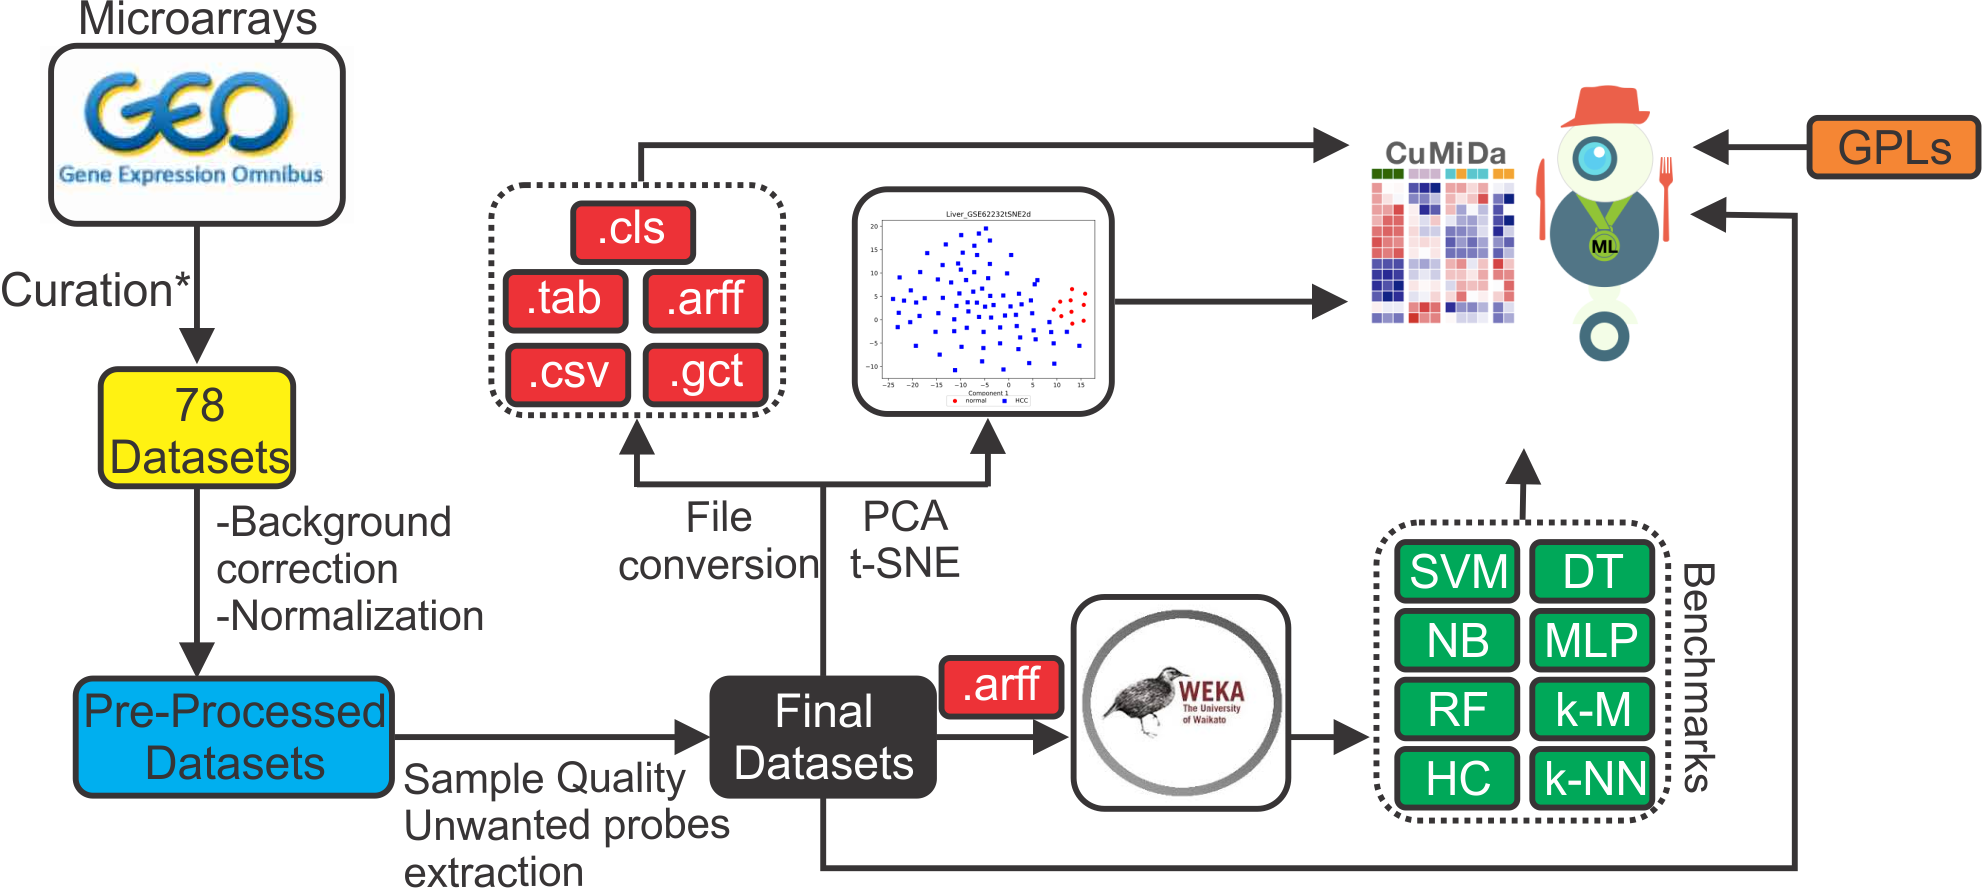

The aim of CuMiDa is to offer homogeneous and state-of-the-art biological preprocessing of these datasets, together with numerous 3-fold cross validation benchmark results to propel machine learning studies focused on cancer research. The database make available various download options to be employed by other programs, as well for PCA and t-SNE results. CuMiDa stands different from existing databases for offering newer datasets, manually and carefully curated, from samples quality, unwanted probes, background correction and normalization, to create a more reliable source of data for computational research.


#### What is microarray?
Microarray Technology - A bioinformatics methodology that enables the simultaneous analysis of the expression levels of thousands of genes within a single experiment. This technology utilizes a collection of microscopic DNA spots affixed to a solid surface, each representing different genes. When RNA samples are introduced to the microarray, specific RNA sequences bind to their complementary DNA spots. The extent of this binding is quantitatively measured, typically through fluorescence techniques, to ascertain the expression level of each gene in the sample. Microarray technology facilitates the comparative analysis of gene expression profiles across various conditions, such as between healthy and diseased states, thereby identifying genes that are significantly upregulated or downregulated. It plays a crucial role in genomics research by providing insights into complex biological pathways, identifying biomarkers for diseases, and discovering potential targets for therapeutic intervention.

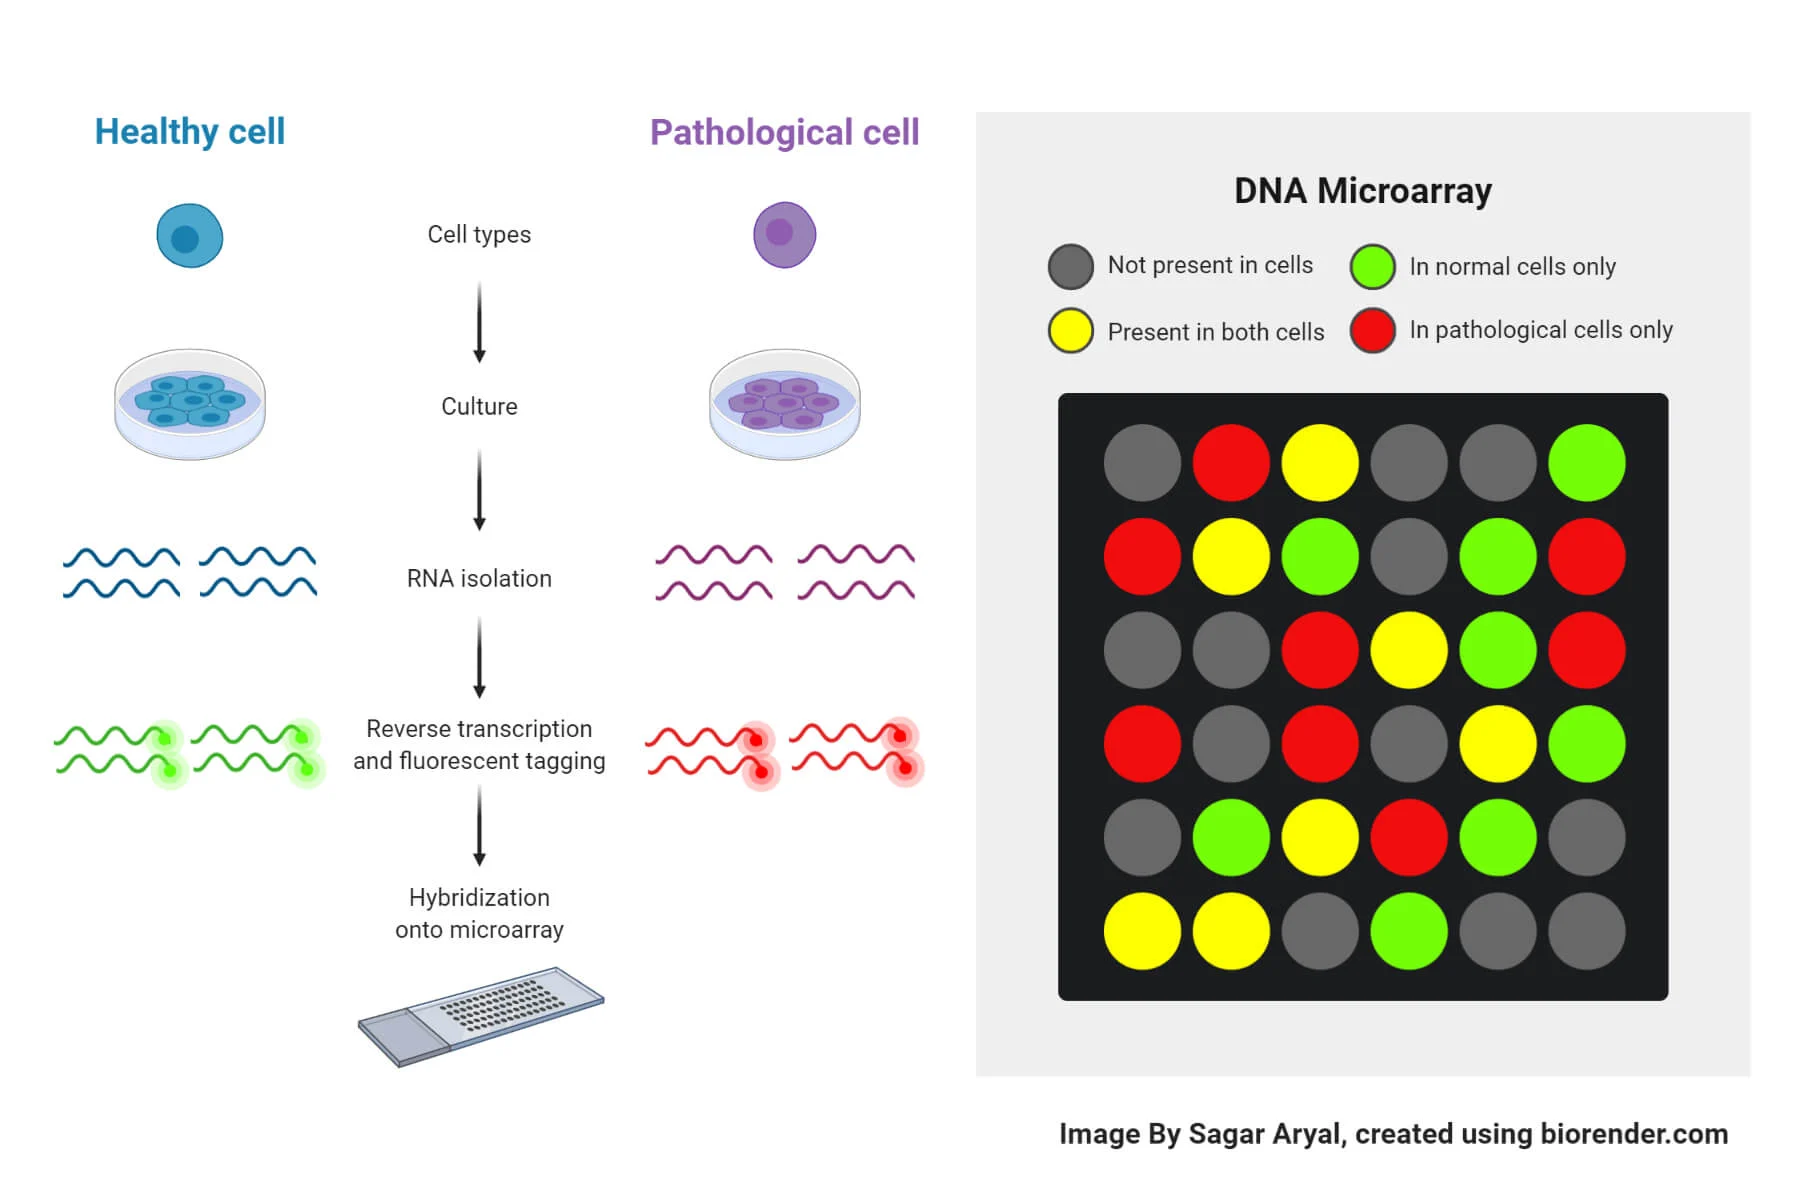

#### Description of project
Our project aims to delve into high-dimensional genetic data to extract critical insights regarding the genes that have the most significant impact on various cancer types. By leveraging advanced bioinformatics techniques, we seek to identify a set of genes that are most informative for the diagnosis and prediction of each type of cancer. To achieve this, we will employ a multifaceted approach that combines dimensionality reduction techniques and feature selection methods to manage and interpret the vast array of genetic information effectively.

A key component of our strategy involves the use of *Bayesian optimization* to enhance the performance of **t-SNE** (t-Distributed Stochastic Neighbor Embedding), a powerful dimensionality reduction technique. This optimization will enable us to refine our data visualization and ensure that the most relevant genetic features are highlighted. Additionally, we will apply statistical tests and mutual information criteria to meticulously select the most insightful genes for our analysis. These methods will allow us to filter through the extensive number of genes, focusing our attention on those that offer the greatest value for understanding and predicting cancer.


In [2]:
df = pd.read_csv("Breast_GSE45827.csv")


## EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Columns: 54677 entries, samples to AFFX-TrpnX-M_at
dtypes: float64(54675), int64(1), object(1)
memory usage: 63.0+ MB


In [5]:
df.head(5)

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,84,basal,9.850040,8.097927,6.424728,7.353027,3.029122,6.880079,4.963740,4.408328,...,12.229711,11.852955,13.658701,13.477698,6.265781,5.016196,4.901594,2.966657,3.508495,3.301999
1,85,basal,9.861357,8.212222,7.062593,7.685578,3.149468,7.542283,5.129607,4.584418,...,12.178531,11.809408,13.750086,13.470146,6.771853,5.291005,5.405839,2.934763,3.687666,3.064299
2,87,basal,10.103478,8.936137,5.735970,7.687822,3.125931,6.562369,4.813449,4.425195,...,12.125108,11.725766,13.621732,13.295080,6.346952,5.171403,5.184286,2.847684,3.550597,3.158535
3,90,basal,9.756875,7.357148,6.479183,6.986624,3.181638,7.802344,5.490982,4.567956,...,12.111235,11.719215,13.743108,13.508861,6.610284,5.193356,5.086569,3.031602,3.524981,3.272665
4,91,basal,9.408330,7.746404,6.693980,7.333426,3.169923,7.610457,5.372469,4.424426,...,12.173642,11.861296,13.797774,13.542206,6.414354,5.040202,5.235318,2.956232,3.445501,3.193947


In [6]:
df.notnull().count()

samples            151
type               151
1007_s_at          151
1053_at            151
117_at             151
                  ... 
AFFX-ThrX-5_at     151
AFFX-ThrX-M_at     151
AFFX-TrpnX-3_at    151
AFFX-TrpnX-5_at    151
AFFX-TrpnX-M_at    151
Length: 54677, dtype: int64

In [7]:
df.notnull().count().min(), df.notnull().count().max()

(151, 151)

As we see above, we don't have any missing values. We deal with an unsual case when our matrix has a few examples and a huge number of features (genes). Thus, we have to be aware of *curse of dimensionality* when working with some methods.

In [9]:
genes_matrix = df.drop(["samples", "type"], axis=1).values
genes_names = df.columns[2:]




color_map = {
    "normal": "#2ca02c",  # Olive green, good for 'normal' to symbolize health
    "HER": "#1f77b4",    # Mutated blue, a stark contrast for highlighting HER
    "luminal_B": "#9467bd",  # Soft purple, distinct yet clearly differentiable
    "luminal_A": "#8c564b",  # Rosy brown, subtle and distinct from luminal_B
    "cell_line": "#ff7f0e",  # Bright orange, stands out for 'cell line'
    "basal": "#d62728"     # Strong red, impactful for highlighting 'basal'
}


cancer_labels = df["type"].values
type_encoder = { t: i for i, t in enumerate(color_map.keys())}

labels = [type_encoder[t] for t in cancer_labels]



I generated a color map that will be hold on futher plots for convience and encoded our labels as integers

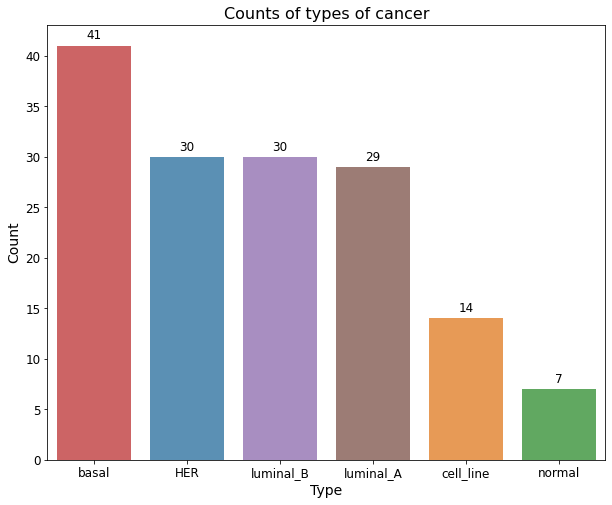

In [10]:
plt.figure(figsize=(10, 8))

value_counts = df["type"].value_counts().reset_index()
value_counts.columns = ['type', 'count']


ax = sns.barplot(x='type', y='count', data=value_counts, palette=color_map, hue="type", alpha=0.8)
ax.set_title('Counts of types of cancer', fontsize=16)
ax.set_xlabel('Type', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.tick_params(labelsize=12)
plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=12)


plt.show()


In some sense, we can say that our data is unbalanced. We especially lack of *normal* cases without any type of cancer as we have only 7 examples that might not be as many as we need. The majority between classes belongs to *basal* type.

In [11]:
print("Min value of gene expression is ", genes_matrix.min())
print("Max value of gene expression is ", genes_matrix.max())
print("Total variance in gene matrix is ", genes_matrix.var())

Min value of gene expression is  2.17109972663613
Max value of gene expression is  14.9701002149474
Total variance in gene matrix is  4.526885278734545


## PCA

Having very high dimensional data limits us in terms of data visualization. This step is a naive trial of plotting our data using **PCA** (Principal Component Analysis) to map our data into **2D** plane by keeping as much *explained variance* as possible.

PCA employs **SVD** (Singular Value Decomposition) on Covariance matrix of our data and select first *K* components with the largest corresponding *eigenvalues* (eigenvalues are proportional to explained variance in case of PCA)

I will try to build PCA with **100 components** to see how fraction of explained variance increases as we add more and more components in PCA. Although, we will be able to plot only **2 components** (at most 3).

In [16]:
%%time

pca = PCA(n_components=100)
pca.fit(genes_matrix)

CPU times: user 11.9 s, sys: 7.49 s, total: 19.4 s
Wall time: 6.48 s


PCA(n_components=100)

In [13]:
%%time 
genes_matrix_pca = pca.transform(genes_matrix)

CPU times: user 360 ms, sys: 140 ms, total: 500 ms
Wall time: 229 ms


In [14]:
genes_matrix_pca.shape

(151, 100)

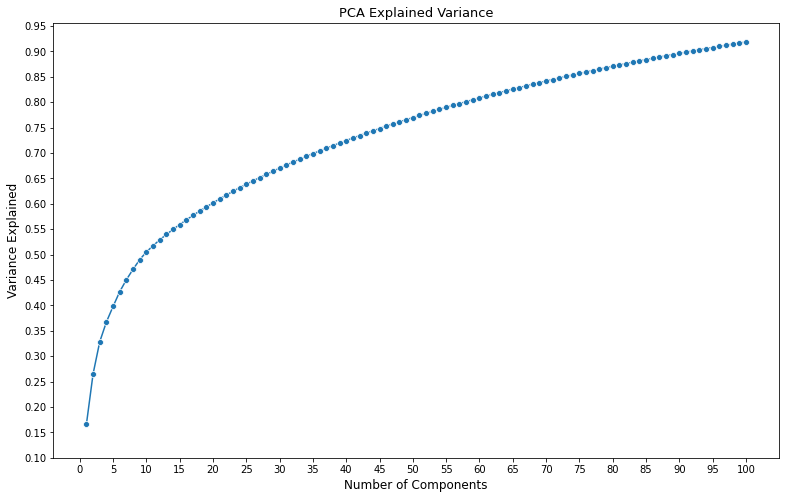

In [17]:
plt.figure(figsize=(13, 8))
sns.lineplot(x=np.arange(1, pca.n_components_ + 1, 1), y=np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.title('PCA Explained Variance', fontsize=13)
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Variance Explained', fontsize=12)
plt.xticks(np.arange(0, 105, 5))
plt.yticks(np.arange(0.1, 1, 0.05))
plt.show()

In [18]:
print("ratio of VAR explained by  first 100 PCs = ", np.sum(pca.explained_variance_ratio_))

ratio of VAR explained by  first 100 PCs =  0.9183799678733222


First **100 components** from PCA are able to explain $92\%$ of Variance in genes data whereas first **two components** can only explain roughly $26\%$ . It actually means that from the 2D plot, we will see the picture that reflecty only 1/4 of the whole variance which is not sufficient to make any decisions about structure of our data.

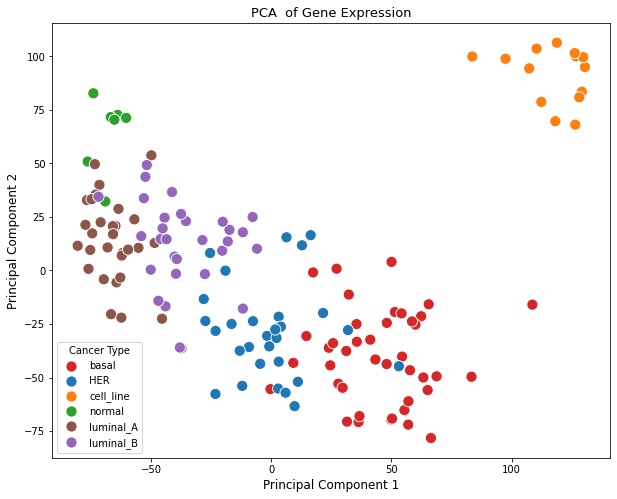

In [19]:
pca_df = pd.DataFrame(genes_matrix_pca[:, :2], columns=['PCA1', 'PCA2'])
pca_df['Label'] = cancer_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Label', palette=color_map, s=125)

plt.title('PCA  of Gene Expression', fontsize=13)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Cancer Type')
plt.show()

This 2D plot does not separate different types well except *cell_line* type and without coloring by labels, we would not be able to see any structure as clusters in this data. The result of PCA tells us that we cannot express linearly  most of the variance among 55k of genes by chosing only 2 principal components.


### T-SNE description

Another way to visualize such high dimensional data is **T-SNE** (t-distributed Stochastic Neighbours Embedding)


**T-SNE** is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two or three-dimensional map. It is based on Stochastic Neighbor Embedding originally developed by Geoffrey Hinton and Sam Roweis, where Laurens van der Maaten proposed the t-distributed variant. It is a nonlinear dimensionality reduction technique for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability. 

The **t-SNE** algorithm comprises two main stages. First, t-SNE constructs a probability distribution over pairs of high-dimensional objects in such a way that similar objects are assigned a higher probability while dissimilar points are assigned a lower probability. Second, t-SNE defines a similar probability distribution over the points in the low-dimensional map, and it minimizes the Kullback–Leibler divergence (KL divergence) between the two distributions with respect to the locations of the points in the map. While the original algorithm uses the Euclidean distance between objects as the base of its similarity metric, this can be changed as appropriate.

## T-SNE visualization

In [21]:

tsne = TSNE(n_components=2,
            init="pca",
            random_state=1)
            

genes_matrix_tsne = tsne.fit_transform(genes_matrix)

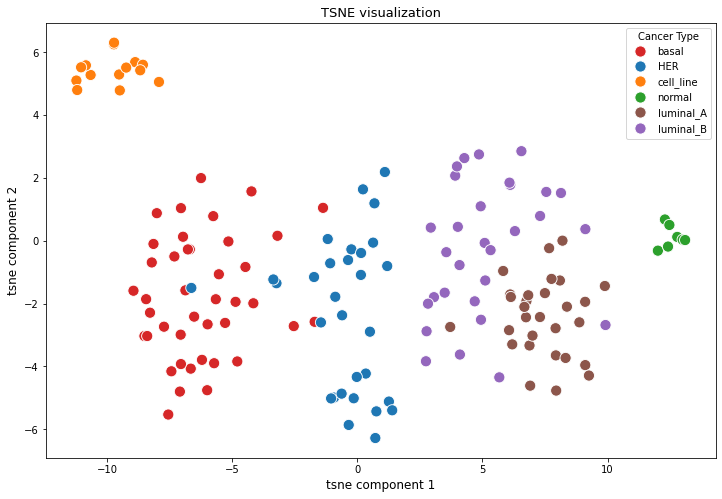

In [23]:
tsne_df = pd.DataFrame(genes_matrix_tsne[:, :2], columns=['tsne_comp1', 'tsne_comp2'])
tsne_df['Label'] = cancer_labels

plt.figure(figsize=(12, 8))
sns.scatterplot(data=tsne_df, x='tsne_comp1', y='tsne_comp2', hue='Label', palette=color_map, s=125)

plt.title('TSNE visualization', fontsize=13)
plt.xlabel('tsne component 1', fontsize=12)
plt.ylabel('tsne component 2', fontsize=12)
plt.legend(title='Cancer Type')
plt.show()

Although, t-SNE did a better job in separating classes and reflecting some structure, it is still messy and hard to differentiate without coloring. This visualization better splits types into clusters and we see that the same types of cancers tend to end up being close to eacho other. Nevertheless, we would like to obtain a better separation of clusters. In order to achieve this goal, we will use two **feature selection** techniques in combination - 

**Mutual Information Score and Chi-Square statistic** to find most infromative genes that help to differentiate between different cancers.

## Gene selection

### Mutual Information


Mutual Information (MI) is a measure from information theory that quantifies the amount of information obtained about one random variable through another random variable. Essentially, it measures the reduction in uncertainty about one variable given that the value of another variable is known. MI is symmetric and non-negative, and it is zero if and only if the variables are independent.

The formula for Mutual Information between two discrete random variables \(X\) and \(Y\) is given by:

$$
I(X; Y) = \sum_{x \in X} \sum_{y \in Y} p(x, y) \log \left(\frac{p(x, y)}{p(x)p(y)}\right)
$$

Where:
- \(I(X; Y)\) is the mutual information between \(X\) and \(Y\),
- \(p(x, y)\) is the joint probability distribution function of \(X\) and \(Y\),
- \(p(x)\) and \(p(y)\) are the marginal probability distribution functions of \(X\) and \(Y\) respectively,
- \(\log\) is the logarithm, the base of which determines the unit of measure of mutual information (commonly base 2 for bits or base \(e\) for nats).

For continuous random variables, the sum is replaced by an integral:

$$
I(X; Y) = \int_{X} \int_{Y} p(x, y) \log \left(\frac{p(x, y)}{p(x)p(y)}\right) dx dy
$$

This formula provides a way to quantify how much knowing one of these variables reduces our uncertainty about the other.


In our case, we will compute **MI** between *each gene* and *labels* to rank all genes we have.

In [23]:
%%time

mi_scores = mutual_info_classif(genes_matrix, labels, random_state=1)

In [22]:

mi_df = pd.DataFrame({"gene" : genes_names, 
                     "MI" : mi_scores})

mi_df = mi_df.sort_values(by="MI", ascending=False)

mi_df.to_csv("genes_MI.csv")


mi_df.head(10)

,gene,MI
20845,211519_s_at,0.917965
19457,210052_s_at,0.866330
11688,202240_at,0.845233
27827,218542_at,0.845002
12227,202779_s_at,0.819782
32506,223229_at,0.806840
13609,204162_at,0.806807
19051,209642_at,0.803727
34448,225191_at,0.802138
18877,209464_at,0.792221


In [25]:
mi_df["MI"].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999])

0.100    0.016808
0.200    0.051215
0.300    0.078727
0.400    0.104878
0.500    0.132005
0.600    0.161793
0.700    0.197437
0.800    0.245639
0.900    0.321369
0.950    0.392730
0.990    0.539691
0.999    0.704228
Name: MI, dtype: float64

A lot of genes turned out to be almost non-informative with respect to types of cancer. Almost half of all our genes have $ MI < 0.1$. 

### Chi-Squared statistic

In the analysis of gene expression data where gene expressions are continuous and the outcome is categorical, the chi-square *chi-square* test can be employed to identify genes that show significant associations with the outcome. This method calculates *chi-square* scores and p-values, providing a statistical basis to select genes whose expression levels are most related to the categorical outcomes.

The formula for computing the chi-square statistic, in a general sense, is:

$$
\chi^2 = \sum \frac{(O - E)^2}{E}
$$

In the context of gene expression data:
- \(O\) represents the observed frequency counts of gene expressions binned into categories corresponding to the outcome classes,
- \(E\) represents the expected frequency counts under the assumption of independence between gene expressions and the outcome,
- The sum is taken over all categories created from the continuous gene expression data and the categorical outcome classes.

The application of the *chi-square* test in this manner allows for the evaluation of the association between each gene's expression and the outcome, with higher *chi-square* scores indicating a stronger association. The resulting p-values help in identifying genes whose association with the outcome is statistically significant, under the chosen level of significance.

The provided code snippet demonstrates how to apply the `chi2` function from *sklearn* machine learning library to compute *chi-square* scores and p-values for a matrix of gene expressions (`genes_matrix`) against categorical labels (`labels`). The results are then organized into a DataFrame, sorted by the *chi-square* scores in descending order, and saved to a CSV file for further analysis. Displaying the top 10 genes provides a quick insight into the genes with the highest statistical significance in their association with the outcome.




In [26]:
%%time 

chi2_scores, chi2_pvals = chi2(genes_matrix, labels)

chi2_df = pd.DataFrame({"gene" : genes_names, 
                     "CHI2" : chi2_scores,
                      "p_value" : chi2_pvals})

chi2_df = chi2_df.sort_values(by="CHI2", ascending=False)

chi2_df.to_csv("genes_chi2.csv")


chi2_df.head(10)

CPU times: user 535 ms, sys: 302 ms, total: 837 ms
Wall time: 544 ms


,gene,CHI2,p_value
37495,228241_at,214.481735,2.258643e-44
46588,237339_at,146.800900,6.402447e-30
15824,206378_at,145.705457,1.094978e-29
14672,205225_at,135.837039,1.371714e-27
18587,209173_at,128.352468,5.322940e-26
14456,205009_at,122.070630,1.143046e-24
37808,228554_at,118.543040,6.386788e-24
14491,205044_at,118.189847,7.586930e-24
33137,223861_at,116.467687,1.756418e-23
46335,237086_at,111.836230,1.676334e-22


## Filtering genes

Once we computed these two scores

In [27]:

mi_selected_genes = mi_df[mi_df["MI"] >= 0.5]

mi_selected_genes

,gene,MI
0,211519_s_at,0.917965
1,210052_s_at,0.866330
2,202240_at,0.845233
3,218542_at,0.845002
4,202779_s_at,0.819782
...,...,...
853,227020_at,0.500298
854,220036_s_at,0.500290
855,1555943_at,0.500095
856,235847_at,0.500090


In [28]:
### selecting genes with chi2 pvalue  < 0.01

chi2_selected_genes  = chi2_df[chi2_df["p_value"] < 0.01]
chi2_selected_genes

,gene,CHI2,p_value
37495,228241_at,214.481735,2.258643e-44
46588,237339_at,146.800900,6.402447e-30
15824,206378_at,145.705457,1.094978e-29
14672,205225_at,135.837039,1.371714e-27
18587,209173_at,128.352468,5.322940e-26
...,...,...,...
40494,231240_at,15.142027,9.772410e-03
21562,212256_at,15.129888,9.821529e-03
34977,225720_at,15.126729,9.834351e-03
24597,215303_at,15.124315,9.844158e-03


In [29]:
selected_genes = list(set(list(mi_selected_genes["gene"]) + list(chi2_selected_genes["gene"])))


genes_selected_both = list(set(mi_selected_genes["gene"]) & set(chi2_selected_genes["gene"]))

print("Number of genes selected by both MI and Chi2:", len(genes_selected_both))
print("Number of genes selected by either MI or Chi2: ",len(selected_genes))

##The most valuable are probably from interesection
genes_selected_both[:10]

Number of genes selected by both MI and Chi2: 416
Number of genes selected by either MI or Chi2:  2194


['218353_at',
 '221561_at',
 '226597_at',
 '204667_at',
 '1555758_a_at',
 '219233_s_at',
 '223121_s_at',
 '222608_s_at',
 '228559_at',
 '229538_s_at']

### try  to visualize using only very important genes

#### PCA on selected genes

In [30]:
genes_matrix_reduced = df[genes_selected_both].values

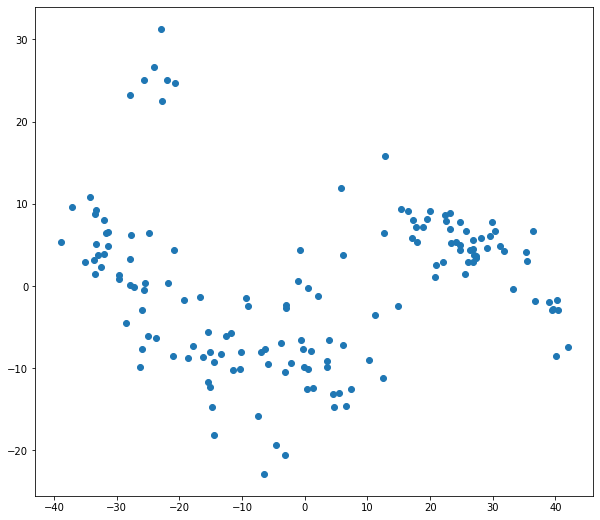

In [31]:
pca_red = PCA(n_components=2)



genes_matrix_reduced_pca = pca_red.fit_transform(genes_matrix_reduced)


plt.figure(figsize=(10, 9))
plt.scatter(genes_matrix_reduced_pca.T[0], genes_matrix_reduced_pca.T[1])

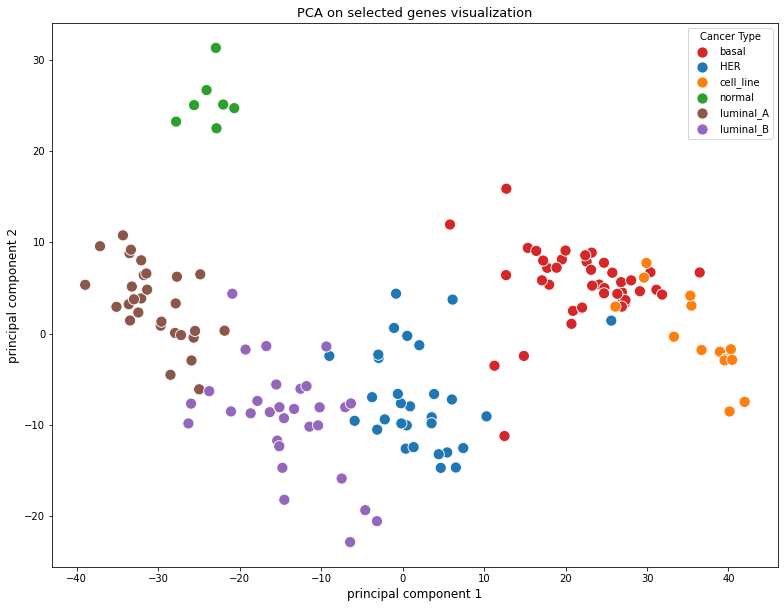

In [32]:
pca_red_df = pd.DataFrame(genes_matrix_reduced_pca[:, :2], columns=['PCA1', 'PCA2'])
pca_red_df['Label'] = cancer_labels

plt.figure(figsize=(13, 10))
sns.scatterplot(data=pca_red_df, x='PCA1', y='PCA2', hue='Label', palette=color_map, s=125)

plt.title('PCA on selected genes visualization', fontsize=13)
plt.xlabel('principal component 1', fontsize=12)
plt.ylabel('principal component 2', fontsize=12)
plt.legend(title='Cancer Type')
plt.show()

### TSNE on selected genes

In [33]:
tsne_red = TSNE(n_components=2,
            init="pca",
            random_state=1
            )


genes_matrix_reduced_tsne = tsne_red.fit_transform(genes_matrix_reduced)

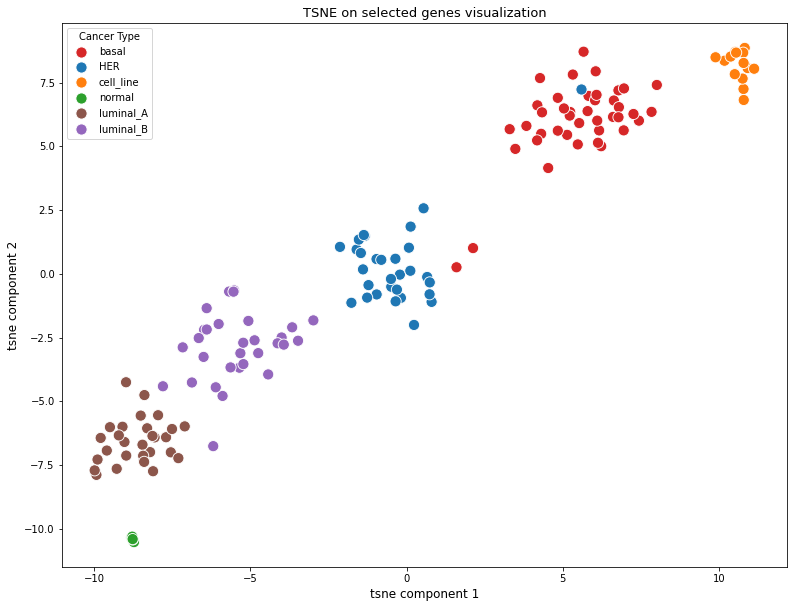

In [58]:
tsne_red_df = pd.DataFrame(genes_matrix_reduced_tsne[:, :2], columns=['axis1', 'axis2'])
tsne_red_df['Label'] = cancer_labels

plt.figure(figsize=(13, 10))
sns.scatterplot(data=tsne_red_df, x='axis1', y='axis2', hue='Label', palette=color_map, s=125)

plt.title('TSNE on selected genes visualization', fontsize=13)
plt.xlabel('tsne component 1', fontsize=12)
plt.ylabel('tsne component 2', fontsize=12)
plt.legend(title='Cancer Type')
plt.show()

### Tuning T-SNE hyperparameters

In [55]:
def compute_KNN_score(X_high_dim, X_low_dim, n_neighbors=5):
    nn_high = NearestNeighbors(n_neighbors=n_neighbors).fit(X_high_dim)
    _, indices_high = nn_high.kneighbors(X_high_dim)
    
    nn_low = NearestNeighbors(n_neighbors=n_neighbors).fit(X_low_dim)
    _, indices_low = nn_low.kneighbors(X_low_dim)
    
    score = sum(len(set(high).intersection(set(low))) for high, low in zip(indices_high, indices_low)) / (len(X_high_dim) * n_neighbors)
    return score

def compute_KNC_score(X_high_dim, X_low_dim, labels, n_neighbors=5):
    classes = np.unique(labels)
    means_high = np.array([X_high_dim[labels == c].mean(axis=0) for c in classes])
    means_low = np.array([X_low_dim[labels == c].mean(axis=0) for c in classes])
    
    nn_high = NearestNeighbors(n_neighbors=n_neighbors).fit(means_high)
    _, indices_high = nn_high.kneighbors(means_high)
    
    nn_low = NearestNeighbors(n_neighbors=n_neighbors).fit(means_low)
    _, indices_low = nn_low.kneighbors(means_low)
    
    score = sum(len(set(high).intersection(set(low))) for high, low in zip(indices_high, indices_low)) / (len(classes) * n_neighbors)
    return score

def compute_CPD_score(X_high_dim, X_low_dim):
    distances_high = pdist(X_high_dim, 'euclidean')
    distances_low = pdist(X_low_dim, 'euclidean')
    
    correlation, _ = spearmanr(distances_high, distances_low)
    return correlation

In [40]:



def save_tsne_plot(X_low_dim, labels, trial_id):
    plt.figure(figsize=(8, 6))
    for i in np.unique(labels):
        plt.scatter(X_low_dim[labels == i, 0], X_low_dim[labels == i, 1], label=i)
    plt.title(f't-SNE Visualization Trial {trial_id}')
    plt.legend()
    plt.savefig(f'tsne_trials/trial_{trial_id}.png')
    plt.close()

def objective(trial):
    X_high_dim = genes_matrix_reduced
    y = labels
    n_classes = len(np.unique(y))
    
    ##TSNE PARAMS
    perplexity = trial.suggest_float('perplexity', 5, 50)
    learning_rate = trial.suggest_float('learning_rate', 10, 1000)
    n_iter = trial.suggest_int('n_iter', 250, 5000)
    early_exaggeration= trial.suggest_int("early_exaggeration", 1, 20)
    
    
    
    tsne = TSNE(perplexity=perplexity,
                learning_rate=learning_rate,
                n_iter=n_iter,
                early_exaggeration = early_exaggeration,
                random_state=42)
    X_low_dim = tsne.fit_transform(X_high_dim)
    
    knn_score = compute_KNN_score(X_high_dim, X_low_dim, n_neighbors=4) #microscopic structure
    knc_score = compute_KNC_score(X_high_dim, X_low_dim, y, n_neighbors=n_classes) 
    cpd_score = compute_CPD_score(X_high_dim, X_low_dim) #Global structure
    
    average_score = (0.8 * knn_score + knc_score +  1.2 * cpd_score) / 3
    save_tsne_plot(X_low_dim, y, trial.number)
    return average_score


os.makedirs('tsne_trials', exist_ok=True)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)




[I 2024-02-12 20:51:43,571] A new study created in memory with name: no-name-daea5685-de08-4a3d-a4d8-5ce124fbcfb8
[I 2024-02-12 20:51:44,718] Trial 0 finished with value: 0.8594261337713389 and parameters: {'perplexity': 16.0526142662008, 'learning_rate': 650.37149326995, 'n_iter': 2473, 'early_exaggeration': 8}. Best is trial 0 with value: 0.8594261337713389.
[I 2024-02-12 20:51:46,490] Trial 1 finished with value: 0.8646602352669204 and parameters: {'perplexity': 29.907442879525476, 'learning_rate': 686.126800215547, 'n_iter': 1902, 'early_exaggeration': 3}. Best is trial 1 with value: 0.8646602352669204.
[I 2024-02-12 20:51:48,412] Trial 2 finished with value: 0.8996468064087271 and parameters: {'perplexity': 8.889773786183166, 'learning_rate': 123.52885256382307, 'n_iter': 2701, 'early_exaggeration': 3}. Best is trial 2 with value: 0.8996468064087271.
[I 2024-02-12 20:51:49,348] Trial 3 finished with value: 0.8928352862679828 and parameters: {'perplexity': 17.1796720331579, 'learni

[I 2024-02-12 20:52:31,927] Trial 32 finished with value: 0.8953846435190388 and parameters: {'perplexity': 12.167609951772238, 'learning_rate': 172.48273300039244, 'n_iter': 1170, 'early_exaggeration': 4}. Best is trial 2 with value: 0.8996468064087271.
[I 2024-02-12 20:52:32,895] Trial 33 finished with value: 0.8713870535977931 and parameters: {'perplexity': 7.454750824907597, 'learning_rate': 70.2232645048037, 'n_iter': 526, 'early_exaggeration': 2}. Best is trial 2 with value: 0.8996468064087271.
[I 2024-02-12 20:52:34,667] Trial 34 finished with value: 0.892094050960777 and parameters: {'perplexity': 15.61702440146422, 'learning_rate': 15.887131524189273, 'n_iter': 1803, 'early_exaggeration': 3}. Best is trial 2 with value: 0.8996468064087271.
[I 2024-02-12 20:52:35,669] Trial 35 finished with value: 0.8889837084220268 and parameters: {'perplexity': 17.968764189866324, 'learning_rate': 127.61308351715367, 'n_iter': 888, 'early_exaggeration': 7}. Best is trial 2 with value: 0.89964

In [41]:
study.best_params

{'perplexity': 6.952086000724197,
 'learning_rate': 323.8851846729418,
 'n_iter': 3954,
 'early_exaggeration': 1}

In [43]:
tsne_tuned = TSNE(**study.best_params, random_state=42)

tuned_tsne_matrix = tsne_tuned.fit_transform(genes_matrix_reduced)

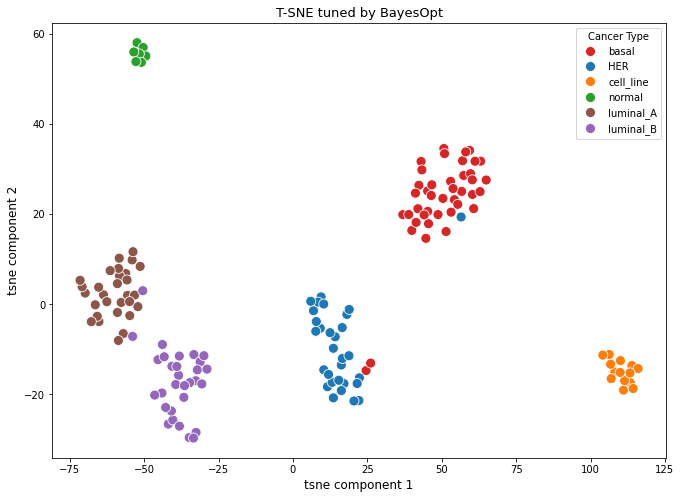

In [57]:
tuned_tsne_df = pd.DataFrame(tuned_tsne_matrix[:, :2], columns=['axis1', 'axis2'])
tuned_tsne_df['Label'] = cancer_labels

plt.figure(figsize=(11, 8))
sns.scatterplot(data=tuned_tsne_df, x='axis1', y='axis2', hue='Label', palette=color_map, s=100)

plt.title('T-SNE tuned by BayesOpt', fontsize=13)
plt.xlabel('tsne component 1', fontsize=12)
plt.ylabel('tsne component 2', fontsize=12)
plt.legend(title='Cancer Type')
plt.show()

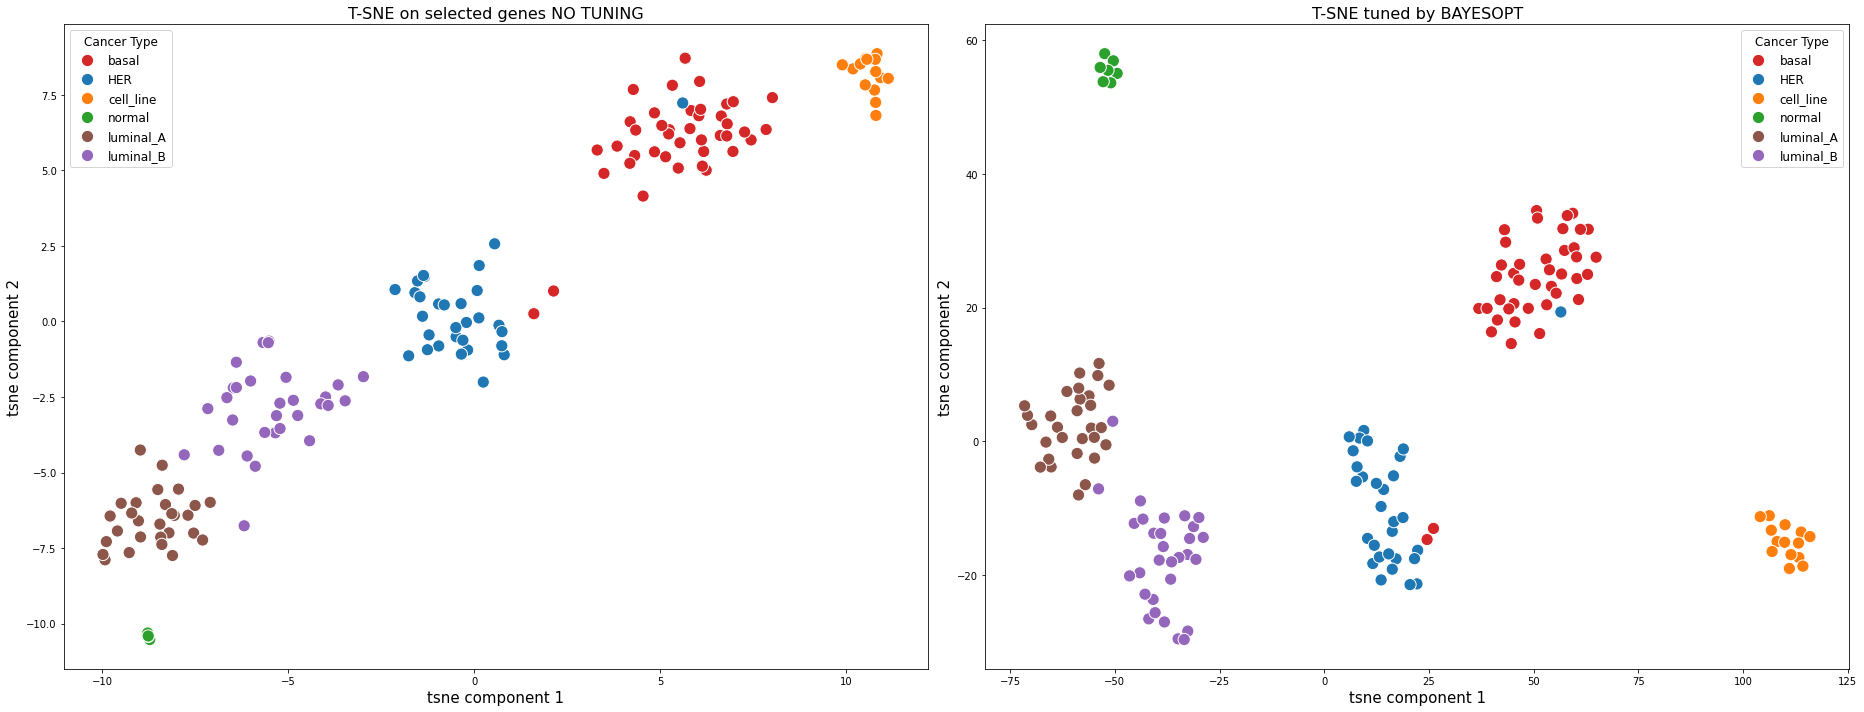

In [59]:
tuned_tsne_df = pd.DataFrame(tuned_tsne_matrix[:, :2], columns=['axis1', 'axis2'])
tuned_tsne_df['Label'] = cancer_labels

fig, axes = plt.subplots(1, 2, figsize=(26, 10))

sns.scatterplot(data=tsne_red_df, x='axis1', y='axis2', hue='Label', palette=color_map, s=150, ax=axes[0])
axes[0].set_title('T-SNE on selected genes NO TUNING', fontsize=16)
axes[0].set_xlabel('tsne component 1', fontsize=15)
axes[0].set_ylabel('tsne component 2', fontsize=15)
axes[0].legend(title='Cancer Type', title_fontsize='large', fontsize='large')

sns.scatterplot(data=tuned_tsne_df, x='axis1', y='axis2', hue='Label', palette=color_map, s=150, ax=axes[1])
axes[1].set_title('T-SNE tuned by BAYESOPT', fontsize=16)
axes[1].set_xlabel('tsne component 1', fontsize=15)
axes[1].set_ylabel('tsne component 2', fontsize=15)
axes[1].legend(title='Cancer Type', title_fontsize='large', fontsize='large')

plt.tight_layout()
plt.show()

## Logistic Regression



In [62]:
logreg = LogisticRegression(penalty="l1",
                            solver="saga",
                            multi_class="ovr",
                            random_state=1
                            )
logreg.fit(genes_matrix_reduced, labels)

LogisticRegression(multi_class='ovr', penalty='l1', random_state=1,
                   solver='saga')

In [63]:
#Extract most important genes



her_coeffs = logreg.coef_[1]
lumB_coeffs = logreg.coef_[2]
lumA_coeffs = logreg.coef_[3]
cellline_coeffs = logreg.coef_[4]
basal_coeffs = logreg.coef_[5]



In [66]:
color_map

{'normal': '#2ca02c',
 'HER': '#1f77b4',
 'luminal_B': '#9467bd',
 'luminal_A': '#8c564b',
 'cell_line': '#ff7f0e',
 'basal': '#d62728'}

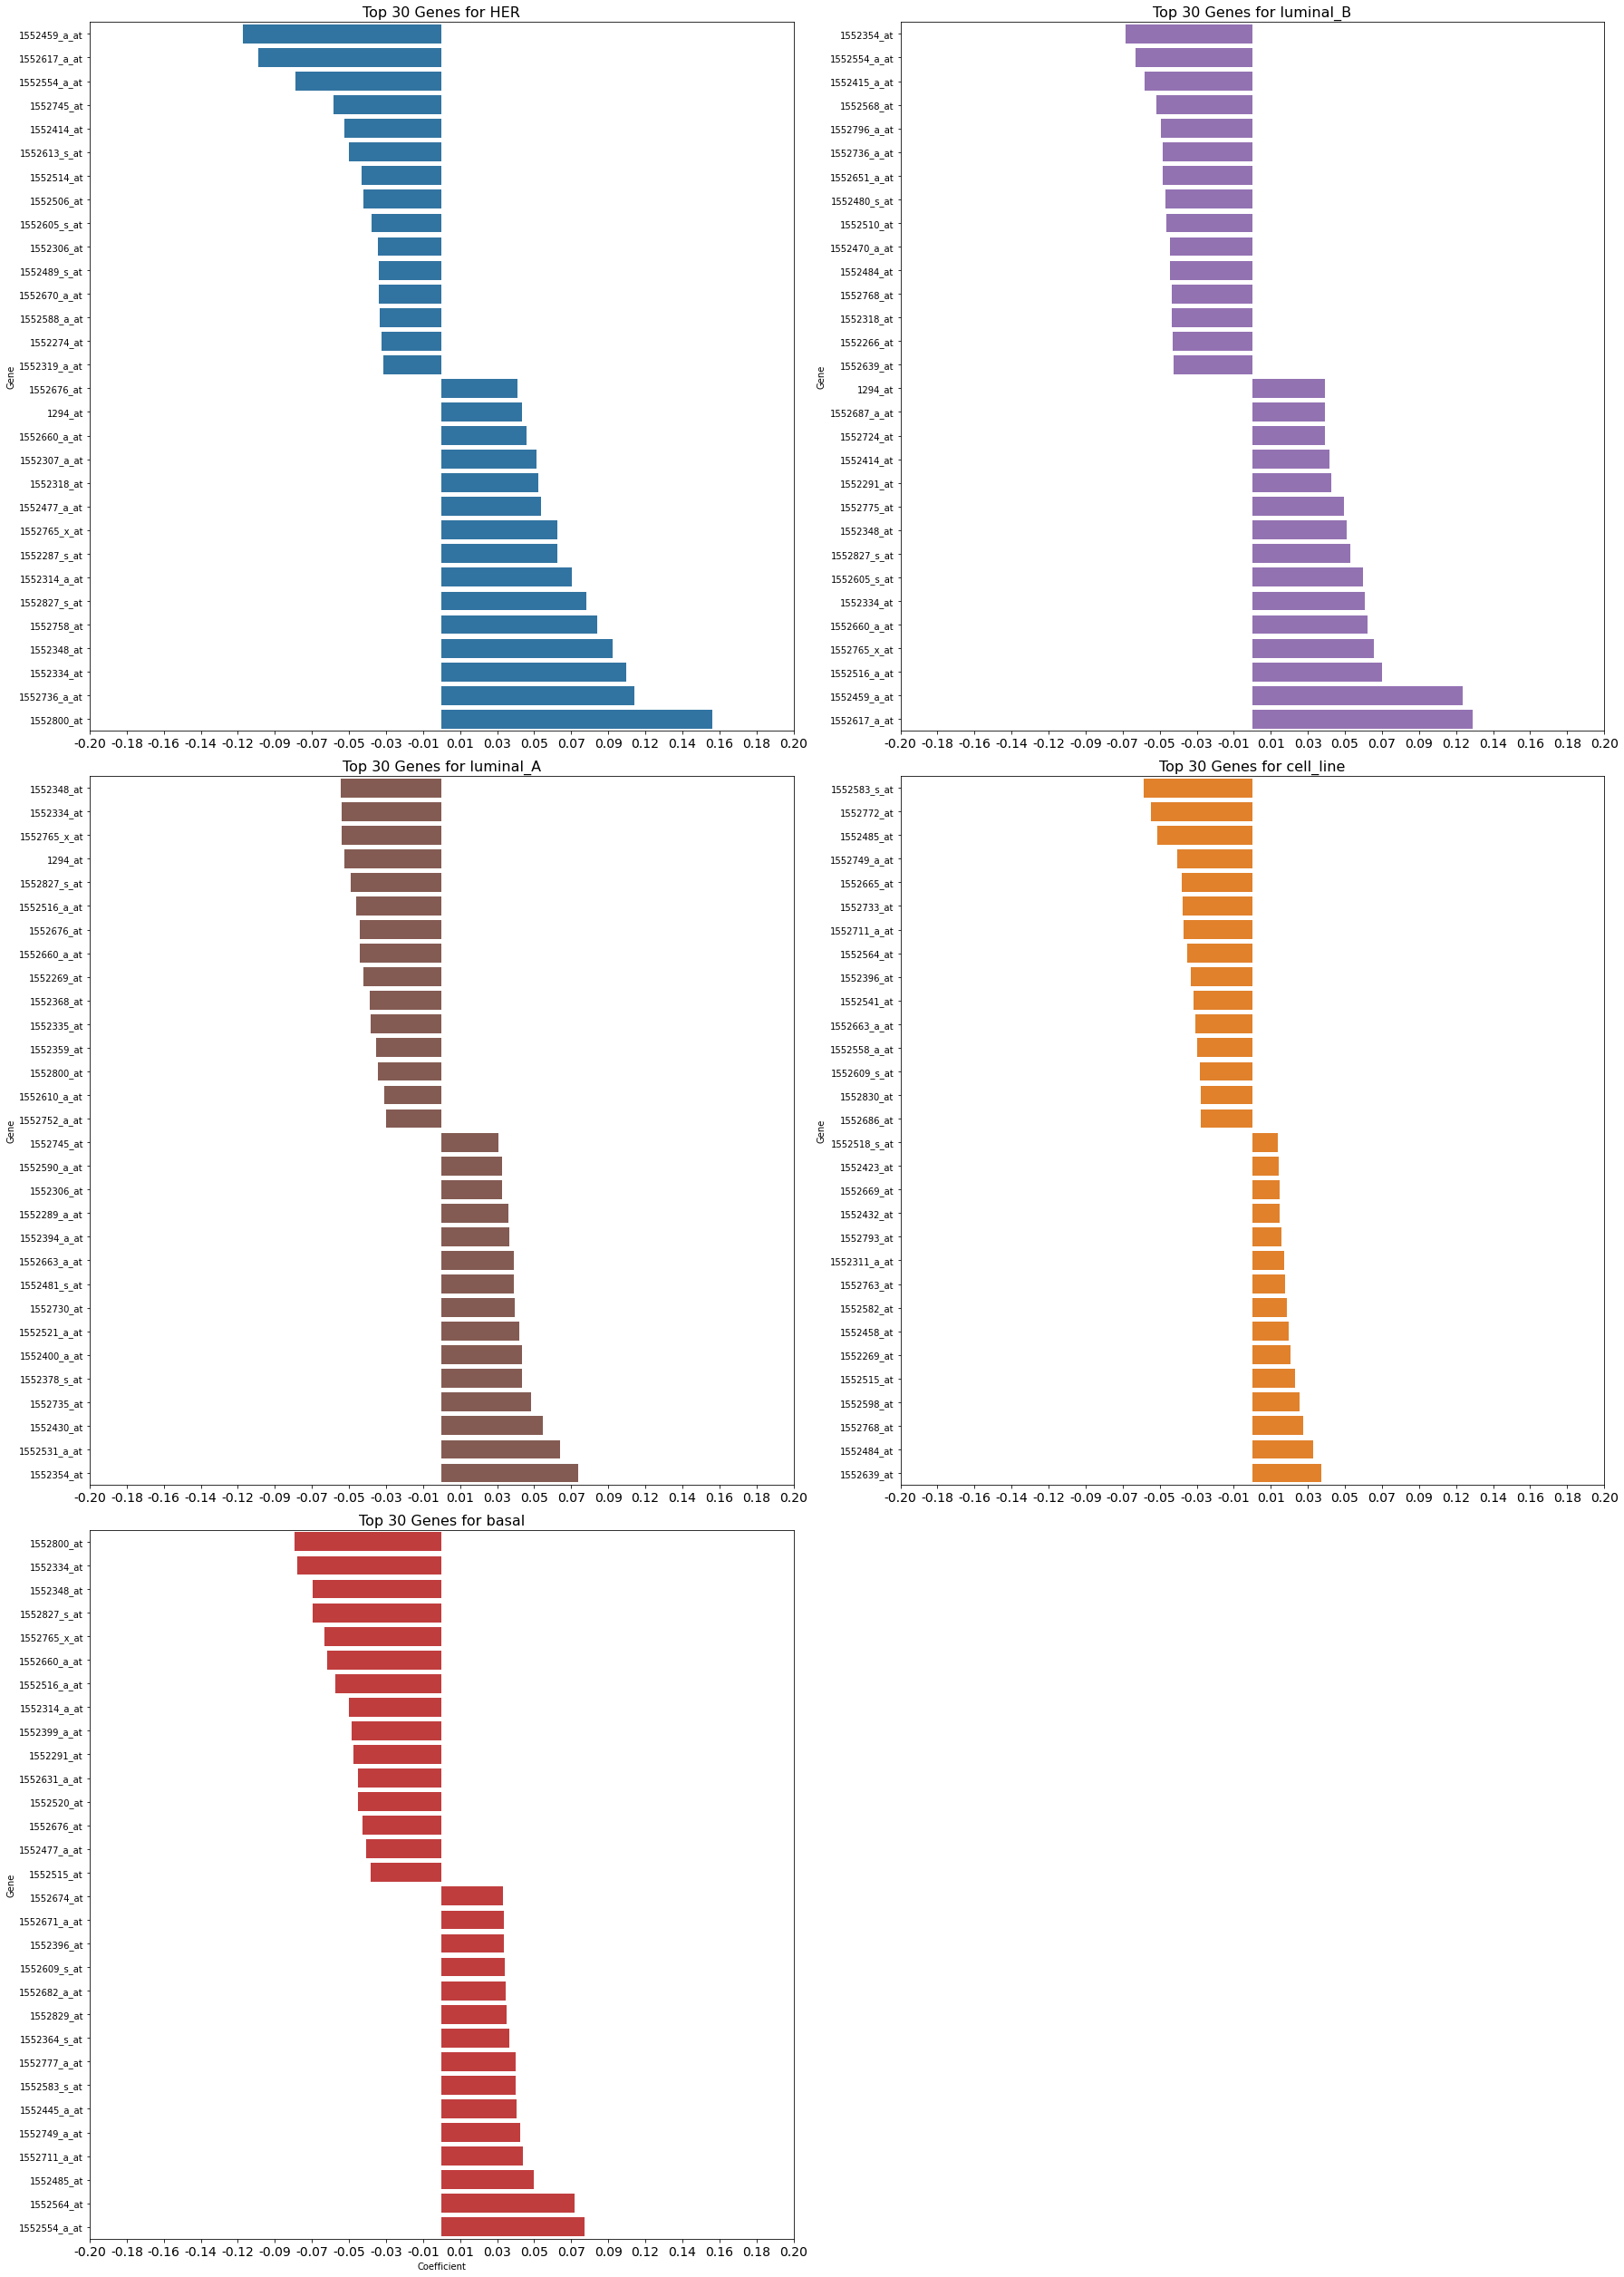

In [79]:
fig, axes = plt.subplots(3, 2, figsize=(25, 35), sharex=True)
categories = ['HER', 'luminal_B', 'luminal_A', 'cell_line', 'basal']
coefficients = [her_coeffs, lumB_coeffs, lumA_coeffs, cellline_coeffs, basal_coeffs]


xticks = np.linspace(-0.2, 0.2, 20)
xtick_labels = [f"{x:.2f}" for x in xticks]

for i, (coef, category) in enumerate(zip(coefficients, categories)):
    ax = axes.flat[i]
    top_indices = list(np.argsort(coef)[-15:]) + list(np.argsort(coef)[:15])
    
    data = pd.DataFrame({'Gene': genes_names[top_indices], 'Coefficient': coef[top_indices]})
    sns.barplot(x='Coefficient', y='Gene', data=data.sort_values('Coefficient', ascending=True), ax=ax, palette=[color_map[category] for _ in range(30)])
    ax.set_title(f'Top 30 Genes for {category}', fontsize=16)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels, fontsize=14)
    ax.xaxis.set_tick_params(which='both', labelbottom=True) 

for j in range(i + 1, 6):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()